In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

In [10]:
random.seed(9)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trnsfrm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


pretrain_path = '/kaggle/input/imagenetmini-1000/imagenet-mini/train'
data_path = '/kaggle/input/my-anomaly-data/MVTec_AD_dataset_formatted/MVTec_AD_dataset_formatted/train'


pretrain_dataset = ImageFolder(root=pretrain_path, transform=transform)
dataset = ImageFolder(root=data_path, transform=transform)


def get_random_indices(full_dataset):
    selected_indices1 = []
    selected_indices2 = []

    for class_idx in range(len(full_dataset.classes)):
        class_indices = [idx for idx, (_, label_idx) in enumerate(full_dataset.imgs) if label_idx == class_idx]
        num_selected = int(len(class_indices) * 0.75)
        selected = random.sample(class_indices, num_selected)
        selected_indices1.extend(selected)
        selected_indices2.extend([x for x in class_indices if x not in selected])

    return selected_indices1, selected_indices2


train_indices, valid_indices = get_random_indices(dataset)


train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Teacher network

In [5]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=384, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.features(x)
        return x


# Student network

In [6]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=4, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=768, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=768, out_channels=768, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        x = self.features(x)
        return x


# Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # EncConv-1
        self.enc_conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)  # EncConv-2
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # EncConv-3
        self.enc_conv4 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)  # EncConv-4
        self.enc_conv5 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)  # EncConv-5
        self.enc_conv6 = nn.Conv2d(64, 64, kernel_size=8, stride=1, padding=0)  # EncConv-6

        # Decoder
        self.bilinear1 = nn.Upsample(scale_factor=3, mode='bilinear')  # Bilinear-1
        self.dec_conv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-1
        self.dropout1 = nn.Dropout2d(p=0.2)  # Dropout-1

        self.bilinear2 = nn.Upsample(scale_factor=2, mode='bilinear')  # Bilinear-2
        self.dec_conv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-2
        self.dropout2 = nn.Dropout2d(p=0.2)  # Dropout-2

        self.bilinear3 = nn.Upsample(scale_factor=2, mode='bilinear')  # Bilinear-3
        self.dec_conv3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-3
        self.dropout3 = nn.Dropout2d(p=0.2)  # Dropout-3

        self.bilinear4 = nn.Upsample(scale_factor=2, mode='bilinear')  # Bilinear-4
        self.dec_conv4 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-4
        self.dropout4 = nn.Dropout2d(p=0.2)  # Dropout-4

        self.bilinear5 = nn.Upsample(scale_factor=2, mode='bilinear')  # Bilinear-5
        self.dec_conv5 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-5
        self.dropout5 = nn.Dropout2d(p=0.2)  # Dropout-5

        self.bilinear6 = nn.Upsample(scale_factor=2, mode='bilinear')  # Bilinear-6
        self.dec_conv6 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=1, padding=2)  # DecConv-6
        self.dropout6 = nn.Dropout2d(p=0.2)  # Dropout-6

        self.bilinear7 = nn.Upsample(scale_factor=0.5, mode='bilinear')  # Bilinear-7
        self.dec_conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # DecConv-7
        self.dec_conv8 = nn.Conv2d(64, 384, kernel_size=3, stride=1, padding=1)  # DecConv-8

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_conv4(x))
        x = F.relu(self.enc_conv5(x))
        x = self.enc_conv6(x)

        # Decoder
        x = self.bilinear1(x)
        x = F.relu(self.dec_conv1(x))
        x = self.dropout1(x)

        x = self.bilinear2(x)
        x = F.relu(self.dec_conv2(x))
        x = self.dropout2(x)

        x = self.bilinear3(x)
        x = F.relu(self.dec_conv3(x))
        x = self.dropout3(x)

        x = self.bilinear4(x)
        x = F.relu(self.dec_conv4(x))
        x = self.dropout4(x)

        x = self.bilinear5(x)
        x = F.relu(self.dec_conv5(x))
        x = self.dropout5(x)

        x = self.bilinear6(x)
        x = F.relu(self.dec_conv6(x))
        x = self.dropout6(x)

        x = self.bilinear7(x)
        x = F.relu(self.dec_conv7(x))
        x = self.dec_conv8(x)

        return x


In [14]:
teacher = Teacher()
teacher.load_state_dict(torch.load('/kaggle/input/my-anomaly-data/Teacher_model_M_5000.pth', map_location=torch.device(device)))

for name, param in teacher.named_parameters():
    param.requires_grad = False
    
student = Student()

autenc = Autoencoder()


if torch.cuda.device_count() > 1:
    teacher = nn.DataParallel(teacher)
    student = nn.DataParallel(student)
    autenc = nn.DataParallel(autenc)

teacher = teacher.to(device)
student = student.to(device)
autenc = teacher.to(device)

In [15]:
mu_channel = []
sig_channel = []

teacher.eval()
for i, (image, _) in enumerate(train_dataloader):
    print(i)
    if i>24:
        break
        
    image = image.to(device)
    
    with torch.no_grad():
        teach_out = teacher(image)

    if i==0:
        sequence = teach_out

    else:
        sequence = torch.cat((sequence, teach_out), dim=0)


sequence = sequence.mean(dim=0)

for tensr in sequence:
    mu_channel.append(tensr.mean().item())
    sig_channel.append(tensr.std().item())
            
    
teach_normalize = transforms.Normalize(mean=mu_channel, std=sig_channel)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [16]:
import gc
gc.collect()

1826

In [17]:
criterion = nn.MSELoss()
ts_crit = nn.MSELoss(reduction='none')

optimizer = torch.optim.Adam([{'params': student.parameters()}, {'params': autenc.parameters()}],
                             lr=1e-4,
                             weight_decay=1e-5)

In [18]:
def augment_image(image, choice, L):
    if choice==1:
        img_transform = transforms.functional.adjust_brightness(image, L)
    elif choice==2:
        img_transform = transforms.functional.adjust_contrast(image, L)
    elif choice==3:
        img_transform = transforms.functional.adjust_saturation(image, L)
            
    return img_transform

In [48]:
random.seed(9)

teacher.eval()
student.train()
autenc.train()

for epoch in range(20000):
    
    img_id = random.choice(train_indices)
    
    original_img = train_dataset[train_indices.index(img_id)][0]
    img = original_img.unsqueeze(0).to(device)

    
    with torch.no_grad():
        t1out = teacher(img)

    t1out = teach_normalize(t1out)

    s1out = student(img)

    s1out1 = s1out[:, :384, :, :]
    
    all_loss = ts_crit(s1out1.squeeze(0), t1out.squeeze(0)).mean(dim=-1).mean(dim=-1)
    phard = torch.kthvalue(all_loss, int(0.999 * all_loss.size(0)), dim=0).values
    mask = all_loss >= phard
    loss1 = all_loss[mask].mean()
    
    random_pt_image = pretrain_dataset[random.choice(range(len(pretrain_dataset)-1))][0]
    pretrain_out = student(random_pt_image.unsqueeze(0).to(device))
    penalty = torch.norm(pretrain_out)/(384*64*64)
    
    loss1 = loss1 + penalty
    


    aug_choice = random.choice([1, 2, 3])
    aug_coeff = random.uniform(0.8, 1.2)

    new_img = augment_image(original_img, aug_choice, aug_coeff)
    new_img = new_img.unsqueeze(0).to(device)


    with torch.no_grad():
        t2out = teacher(new_img)

    t2out = teach_normalize(t2out)

    s2out = student(new_img)
    s2out2 = s2out[:, 384:, :, :]

    aout = autenc(new_img)

    loss2 = criterion(t2out, aout)
    loss3 = criterion(aout, s2out2)

    loss = loss1 + loss2 + loss3
    
    if epoch==0 or (epoch+1)%1000==0:
        print(f"Epoch: {epoch+1}; Loss: {loss.item()}")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1; Loss: 8.134994506835938
Epoch: 1000; Loss: 18.510026931762695
Epoch: 2000; Loss: 14.187213897705078
Epoch: 3000; Loss: 10.410896301269531
Epoch: 4000; Loss: 11.871844291687012
Epoch: 5000; Loss: 8.285367965698242
Epoch: 6000; Loss: 12.168424606323242
Epoch: 7000; Loss: 20.31467056274414
Epoch: 8000; Loss: 6.639761447906494
Epoch: 9000; Loss: 11.313941955566406
Epoch: 10000; Loss: 8.584526062011719
Epoch: 11000; Loss: 8.674140930175781
Epoch: 12000; Loss: 9.716497421264648
Epoch: 13000; Loss: 9.66769790649414
Epoch: 14000; Loss: 8.084966659545898
Epoch: 15000; Loss: 7.06307315826416
Epoch: 16000; Loss: 9.562267303466797
Epoch: 17000; Loss: 7.883780479431152
Epoch: 18000; Loss: 7.232539653778076
Epoch: 19000; Loss: 8.98031997680664
Epoch: 20000; Loss: 7.7442708015441895


In [49]:
xst = []
xae = []

teacher.eval()
student.eval()
autenc.eval()

for i, (val1, _) in enumerate(valid_dataset):
    val1 = val1.unsqueeze(0).to(device)
    
    with torch.no_grad():
        tvout = teacher(val1)
        svout = student(val1)
        aeout = autenc(val1)
        
    tvout = teach_normalize(tvout)

    svout1 = svout[:, :384, :, :]
    svout2 = svout[:, 384:, :, :]

    dst = []
    for a1, b1 in zip(tvout[0], svout1[0]):
        dst.append(ts_crit(a1, b1))

    dst = torch.stack(dst)

    dstae = []
    for a2, b2 in zip(aeout[0], svout2[0]):
        dstae.append(ts_crit(a2, b2))

    dstae = torch.stack(dstae)

    mst = dst.sum(dim=0)/384
    mae = dstae.sum(dim=0)/384

    mst = F.interpolate(mst.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0)
    mae = F.interpolate(mae.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0)
    
    xst.append(mst)
    xae.append(mae)
    
    
xst = torch.stack(xst)
xae = torch.stack(xae)

In [50]:
qast, qbst = np.percentile(xst.view(-1).cpu().numpy(), [90, 99.5])
qaae, qbae = np.percentile(xae.view(-1).cpu().numpy(), [90, 99.5])

In [51]:
test_path = '/kaggle/input/my-anomaly-data/MVTec_AD_dataset_formatted/MVTec_AD_dataset_formatted/test'

test_dataset = ImageFolder(root=test_path)

In [52]:
def get_mask(test_image):
    teacher.eval()
    student.eval()
    autenc.eval()

    with torch.no_grad():
        tvout = teacher(test_image)
        svout = student(test_image)
        aeout = autenc(test_image)

    tvout = teach_normalize(tvout)

    svout1 = svout[:, :384, :, :]
    svout2 = svout[:, 384:, :, :]

    dst = []
    for a1, b1 in zip(tvout[0], svout1[0]):
        dst.append(ts_crit(a1, b1))

    dst = torch.stack(dst)

    dstae = []
    for a2, b2 in zip(aeout[0], svout2[0]):
        dstae.append(ts_crit(a2, b2))

    dstae = torch.stack(dstae)

    mst = dst.sum(dim=0)/384
    mae = dstae.sum(dim=0)/384

    mst = F.interpolate(mst.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0)
    mae = F.interpolate(mae.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear').squeeze(0)
    
    nmst = 0.1 * ((mst - qast)/(qbst - qast))
    nmae = 0.1 * ((mae - qaae)/(qbae - qaae))
    M = (0.5*nmst) + (0.5*nmae)
    mscore = torch.max(M.view(-1))
    
    return M, mscore

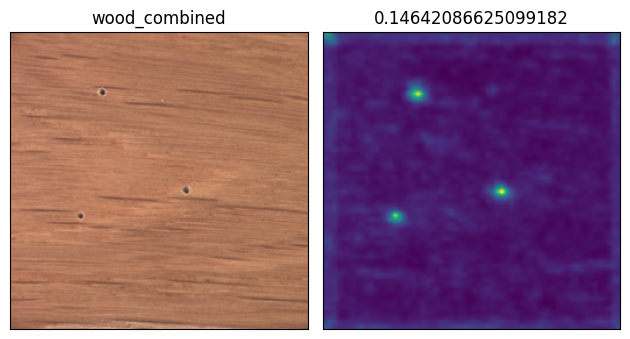

In [73]:
import matplotlib.pyplot as plt

# for timg, label in test_dataset:
#     if label==0:
#         for_mask = transform(timg).unsqueeze(0).to(device)
#         orig_img = trnsfrm(timg)
#         break
        
rand_ind = random.choice(range(len(test_dataset)))
timg = test_dataset[rand_ind][0]
for_mask = transform(timg).unsqueeze(0).to(device)
orig_img = trnsfrm(timg)
        
img_mask, mscore = get_mask(for_mask)

plt.subplot(1, 2, 1)
plt.imshow(orig_img.transpose(0,2))
plt.title(f'{test_dataset.classes[test_dataset[rand_ind][1]]}')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_mask.cpu().transpose(0,2))
plt.title(str(mscore.item()))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

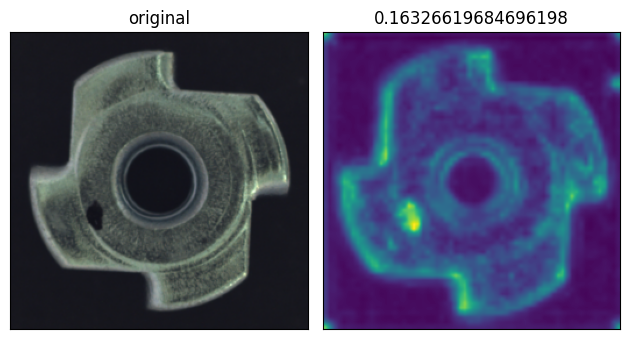

In [16]:
for timg, label in test_dataset:
    if label==1:
        for_mask = transform(timg).unsqueeze(0).to(device)
        orig_img = trnsfrm(timg)
        break
        
img_mask, mscore = get_mask(for_mask)

plt.subplot(1, 2, 1)
plt.imshow(orig_img.transpose(0,2))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_mask.cpu().transpose(0,2))
plt.title(str(mscore.item()))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

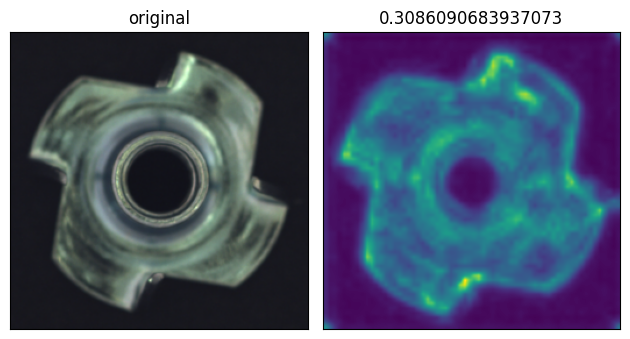

In [17]:
for timg, label in test_dataset:
    if label==2:
        for_mask = transform(timg).unsqueeze(0).to(device)
        orig_img = trnsfrm(timg)
        break
        
img_mask, mscore = get_mask(for_mask)

plt.subplot(1, 2, 1)
plt.imshow(orig_img.transpose(0,2))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_mask.cpu().transpose(0,2))
plt.title(str(mscore.item()))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

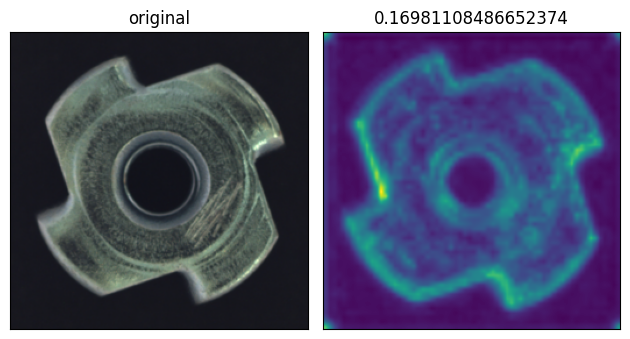

In [18]:
for timg, label in test_dataset:
    if label==4:
        for_mask = transform(timg).unsqueeze(0).to(device)
        orig_img = trnsfrm(timg)
        break
        
img_mask, mscore = get_mask(for_mask)

plt.subplot(1, 2, 1)
plt.imshow(orig_img.transpose(0,2))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(img_mask.cpu().transpose(0,2))
plt.title(str(mscore.item()))
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

In [74]:
import os
import imageio
import cv2

output_root = '/kaggle/working/results'
os.mkdir(output_root)

test_classes = test_dataset.classes


for cl_id in range(len(test_classes)):
    os.mkdir(os.path.join(output_root, test_classes[cl_id]))
    test_batch = [images for images, label in test_dataset if label==cl_id]
    folder_path = os.path.join(output_root, test_classes[cl_id])
    
    for iid, img in enumerate(test_batch):
        
        img = transform(img).unsqueeze(0).to(device)
        anom_mask, _ = get_mask(img)
        anom_mask = anom_mask.cpu().transpose(0,2)
        anom_mask = cv2.resize(anom_mask.numpy(), (700, 700), cv2.INTER_LINEAR)
        anom_mask = cv2.flip(anom_mask, 1)
        anom_mask = cv2.rotate(anom_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
        file_path = os.path.join(folder_path, str(iid).zfill(3)+".tiff")
        
        imageio.imwrite(file_path, anom_mask)
        
        

In [75]:
import zipfile

folder_name = "/kaggle/working/results"

zip_file_name = "results.zip"

with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            zipf.write(os.path.join(root, file))


In [76]:
torch.save(student.module.state_dict(), 'student_model_all.pth')
torch.save(autenc.module.state_dict(), 'autoencoder_EAD_all.pth')